In [1]:
#API and numerical imports
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playergamelog, boxscoreadvancedv3
from nba_api.stats.library.parameters import Season, SeasonType
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

In [2]:
#Machine learning imports
from sklearn.model_selection import train_test_split
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [3]:
#Predict above/below this number
point_threshold = '31.5' 

In [4]:
#Retrieve player info (id, first name, last name, is_active, etc.
player_full_name = "Jayson Tatum"
player_details = [p for p in players.get_players() if p["full_name"] == player_full_name][0]

In [5]:
#Retrieve all the seasons the player has been in the league
career_stats = playercareerstats.PlayerCareerStats(player_id=player_details['id']).get_data_frames()[0]
seasons = career_stats['SEASON_ID']

In [6]:
#Fix type of season
season_type = SeasonType.regular

In [7]:
#Retrieve game-by-game stats for player 
season_data = {}
for s in seasons:
    season_data[s] = playergamelog.PlayerGameLog(player_id=player_details['id'], season=s, season_type_all_star=season_type).get_data_frames()[0]

In [8]:
"""
For each game, we want to extract the following information for training:
1. Opponent
2. Player's team
3. Days since last game
4. Game number
5. Average PPG since start of season
"""


"\nFor each game, we want to extract the following information for training:\n1. Opponent\n2. Player's team\n3. Days since last game\n4. Game number\n5. Average PPG since start of season\n"

In [9]:
#Form training arrays
#Entries in each tuple agree with the above
X = []
#Y will be 1 if player scores above threshold, 0 if below
Y = []

In [10]:
#Label training data
for season in season_data.keys():
    currSeason = season_data[season]
    for ind in currSeason.index:
        if float(currSeason['PTS'][ind]) > float(point_threshold):
            Y.append(1)
        else:
            Y.append(0)

In [11]:
print(len(Y))

458


In [12]:
def correct_id(abbrev):
    if abbrev == "NJN":
        return "BKN"
    elif abbrev == "NOH" or abbrev == "NOK":
        return "NOP"
    elif abbrev == "SEA":
        return "OKC"
    elif abbrev == "PHO":
        return "PHX"
    elif abbrev == "GOS":
        return "GSW"
    else:
        return abbrev

In [13]:
def get_team_id_from_abbrev(abbrev):
    abbrev = correct_id(abbrev)
    return [t for t in teams.get_teams() if t['abbreviation'] == abbrev][0]['id']

In [14]:
#Collect player team and opponent team IDs for training data
player_team_ids = []
opp_team_ids = []
for season in season_data.keys():
    currSeason = season_data[season]
    for ind in currSeason.index:
        matchup = str(currSeason['MATCHUP'][ind])
        player_team_abbrev = matchup[0:3]

        #@ index
        if "@" in matchup:
            opp_team_abbrev = matchup[6:]
        elif "vs." in matchup:
            opp_team_abbrev = matchup[8:]
        else:
            raise Exception("Unconforming matchup string: " + matchup)

        player_team_ids.append(get_team_id_from_abbrev(player_team_abbrev))
        opp_team_ids.append(get_team_id_from_abbrev(opp_team_abbrev))

In [15]:
#Get defensive rating


In [16]:
months = {
    "JAN": 1,
    "FEB": 2,
    "MAR": 3,
    "APR": 4,
    "MAY": 5,
    "JUN": 6,
    "JUL": 7,
    "AUG": 8,
    "OCT": 10,
    "NOV": 11,
    "DEC": 12
}
def convert_human_date(d):
    month = months[d[0:3]]
    day = int(d[4:6])
    year = int(d[8:])

    return date(year, month, day)
    

In [17]:
def distance_between_dates(d1, d2):
    return int((d2 - d1).days)

In [18]:
#default days of rest set for the first game of the season:
first_game_rest = 7

In [19]:
#Compute days since last game
days_since_last_game = []
for season in season_data.keys():
    currSeason = season_data[season]
    for ind in currSeason.index:
        if (ind + 1) == len(currSeason.index):
            days_since_last_game.append(first_game_rest)
        else:
            currGameDate = convert_human_date(str(currSeason["GAME_DATE"][ind]))
            lastGameDate = convert_human_date(str(currSeason["GAME_DATE"][ind+1]))
            days_since_last_game.append(distance_between_dates(lastGameDate, currGameDate))
            

In [20]:
#Get the game number, in terms of the number of games that player has played in the season
game_numbers = []
for season in season_data.keys():
    for ind in season_data[season].index:
        game_numbers.append(len(season_data[season].index) - ind)

In [21]:
#default average ppg since start of season for player
default_first_game_ppg = 0.0

In [22]:
#Compute average ppg since start of season
average_ppg = []
for season in season_data.keys():
    currSeason = season_data[season]
    for ind in currSeason.index:
        if (ind + 1) == len(currSeason.index):
            average_ppg.append(default_first_game_ppg)
        else:
            sum = 0.0
            for pts in currSeason["PTS"][ind+1:len(currSeason.index)]:
                sum += float(pts)
            average_ppg.append(sum / (len(currSeason.index) - ind - 1))

In [23]:
#Zip together all the training input data
for i in range(len(game_numbers)):
    X.append([float(player_team_ids[i]), float(opp_team_ids[i]), float(days_since_last_game[i]), float(game_numbers[i]), average_ppg[i]])

In [24]:
"""
Below we start doing preprocessing
"""

'\nBelow we start doing preprocessing\n'

In [25]:
Y = pd.DataFrame(Y)

In [26]:
X = pd.DataFrame(X)

In [27]:
print(len(Y.index))

458


In [28]:
scaler = MinMaxScaler()
scaler.fit(X)
t_X = scaler.transform(X)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(t_X, Y, test_size=0.25, random_state=0)

In [30]:
"""
Next, we begin constructing the classification model
"""

'\nNext, we begin constructing the classification model\n'

In [31]:
basic_model = Sequential()

In [32]:
basic_model.add(Dense(units=60, activation='relu', input_shape=(5,)))
basic_model.add(Dense(units=40, activation='relu'))
basic_model.add(Dense(units=20, activation='sigmoid'))
basic_model.add(Dense(1, activation='sigmoid'))

In [33]:
adam = keras.optimizers.legacy.Adam(learning_rate=0.001)

In [34]:
basic_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [35]:
#Fit model

In [36]:
basic_model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 0s 732us/step - loss: 0.6108 - accuracy: 0.8163
Epoch 2/100
11/11 [==============================] - 0s 674us/step - loss: 0.5571 - accuracy: 0.8163
Epoch 3/100
11/11 [==============================] - 0s 490us/step - loss: 0.5178 - accuracy: 0.8163
Epoch 4/100
11/11 [==============================] - 0s 481us/step - loss: 0.4914 - accuracy: 0.8163
Epoch 5/100
11/11 [==============================] - 0s 478us/step - loss: 0.4875 - accuracy: 0.8163
Epoch 6/100
11/11 [==============================] - 0s 561us/step - loss: 0.4846 - accuracy: 0.8163
Epoch 7/100
11/11 [==============================] - 0s 498us/step - loss: 0.4833 - accuracy: 0.8163
Epoch 8/100
11/11 [==============================] - 0s 436us/step - loss: 0.4810 - accuracy: 0.8163
Epoch 9/100
11/11 [==============================] - 0s 466us/step - loss: 0.4802 - accuracy: 0.8163
Epoch 10/100
11/11 [==============================] - 0s 466us/step - loss: 0.4786 - accura

In [37]:
#Evaluate on test data

In [38]:
loss_and_metrics = basic_model.evaluate(X_test, Y_test)
print(loss_and_metrics)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

4/4 [==============================] - 0s 717us/step - loss: 0.4914 - accuracy: 0.7913
[0.4913550019264221, 0.791304349899292]
Loss =  0.4913550019264221
Accuracy =  0.791304349899292


4/4 [==============================] - 0s 485us/step


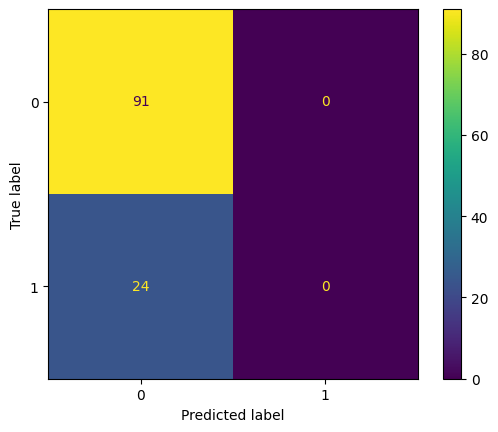

In [39]:
#Get confusion matrix
predicted = basic_model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(Y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [40]:
"""
Next, we have tools to calculate the desired input data for a player, to be used for predictions
"""

'\nNext, we have tools to calculate the desired input data for a player, to be used for predictions\n'

In [41]:
player_team_abbrev = "BOS"
opp_abbrev = "IND"
game_date = "DEC 04, 2023"

In [42]:
opp_id, player_team_id = get_team_id_from_abbrev(opp_abbrev), get_team_id_from_abbrev(player_team_abbrev)
days_elapsed = (convert_human_date(game_date) - convert_human_date(season_data["2023-24"]["GAME_DATE"][0])).days
game_number = len(season_data["2023-24"].index) + 1
average_ppg = 0.0
currSeason = season_data['2023-24']
for ind in currSeason.index:
        if (ind + 1) == len(currSeason.index):
            average_ppg = (default_first_game_ppg)
        else:
            sum = 0.0
            for pts in currSeason["PTS"][ind+1:len(currSeason.index)]:
                sum += float(pts)
            average_ppg = (sum / (len(currSeason.index) - ind - 1))
input = pd.DataFrame([[float(player_team_id), float(opp_id), float(days_elapsed), float(game_number), float(average_ppg)]])

In [43]:
print(input)

              0             1    2     3    4
0  1.610613e+09  1.610613e+09  3.0  20.0  0.0


In [44]:
prediction = basic_model.predict(input)

1/1 [==============================] - 0s 19ms/step


In [45]:
print(prediction)

[[0.00912529]]
